# Introduction 

The goal of this project is to develop a machine learning pipeline that automates the process of retraining and fine-tuning the model on a monthly basis. The machine learning model in question here is a LightGBM ML model which predicts the risk of loan applications. The machine learning pipeline will ensure that the model stays up-to-date with the latest data in order to avoid feature drifts and hence loss in accuracy of the model over time. 

To build a machine learning pipeline for the problem described above, the solution is broken into 3 parts:
   - Build a simple LightGBM machine learning model to predict risk 
   - Plan and write documentation on the construction of the machine learning pipeline
   - Build the machine learning pipeline using the model from step 1
    
In this notebook we will be focusing on step 1 which is developing the LightGBM model

# Building the LightGBM model

Predicting whether a loan application will default or be repaid is a binary classification task which will be tackled using a LightGBM machine learning model

## Step 1: Importing Libraries/Dependencies to be used

In [1]:
#libraries for data exploration and preprocessing
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import sklearn.metrics as metrics
import numpy as np

#library for graph plotting 
import matplotlib.pyplot as plt
import seaborn as sn

#library for model building 
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV

import pickle

## Step 2: Exploratory Data Analysis (EDA)

In [2]:
#reading data
df = pd.read_csv("../data/loan.csv", parse_dates=['applicationDate', 'originatedDate'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   loanId                            577426 non-null  object        
 1   anon_ssn                          577682 non-null  object        
 2   payFrequency                      576409 non-null  object        
 3   apr                               573760 non-null  float64       
 4   applicationDate                   577682 non-null  datetime64[ns]
 5   originated                        577682 non-null  bool          
 6   originatedDate                    46044 non-null   datetime64[ns]
 7   nPaidOff                          577658 non-null  float64       
 8   approved                          577682 non-null  bool          
 9   isFunded                          577682 non-null  int64         
 10  loanStatus                      

In [4]:
df.describe()

,apr,nPaidOff,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF
count,573760.000000,577658.000000,577682.000000,575432.000000,577682.000000,577682.000000,577682.000000
mean,553.080972,0.037887,0.067480,514.245084,1428.897209,7.854389,0.619187
std,110.046159,0.333366,0.250852,320.939929,925.009141,12.853451,0.485587
min,0.000000,0.000000,0.000000,0.000000,-816.710000,0.000000,0.000000
25%,490.000000,0.000000,0.000000,350.000000,1023.640000,3.000000,0.000000
50%,590.000000,0.000000,0.000000,500.000000,1245.250000,3.000000,1.000000
75%,601.000000,0.000000,0.000000,500.000000,1615.660000,6.000000,1.000000
max,705.590000,21.000000,1.000000,5000.000000,19963.630000,200.000000,1.000000


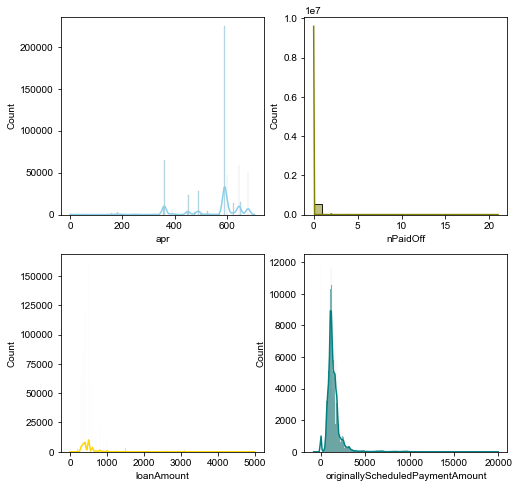

In [5]:
#getting data insights. Plotting data distribution for the features 
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sn.histplot(data=df, x="apr", kde=True, color="skyblue", ax=axs[0, 0])
sn.histplot(data=df, x="nPaidOff", kde=True, color="olive", ax=axs[0, 1])
sn.histplot(data=df, x="loanAmount", kde=True, color="gold", ax=axs[1, 0])
sn.histplot(data=df, x="originallyScheduledPaymentAmount", kde=True, color="teal", ax=axs[1, 1])
sn.set(style="darkgrid")

# Saving the figure.
plt.savefig("ppt_images/data_dist.jpg")

plt.show()

## Preprocessing 

Here we will be going through all the variables as well as feature engineering to ensure we only use variables which are most useful for predicting whether a loan application will default

### Data Cleaning

In [6]:
#filter out for funded loans
df = df.query('isFunded == 1')
df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
15,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28 19:54:22.982,True,2016-11-29 20:30:40.640,2.0,True,1,New Loan,350.0,893.88,MO,organic,0,Checked,NaN,0
33,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01 15:55:41.823,True,2017-03-01 16:15:13.016,0.0,True,1,New Loan,400.0,1364.87,NJ,lead,40,Checked,58b6eef8e4b0b6fca82fd426,1
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577564,LL-I-12367915,55392b05f72f8c3e32e5157612406ba8,B,565.0,2016-12-01 16:57:49.231,True,2016-12-01 17:28:21.872,3.0,True,1,Paid Off Loan,600.0,1670.18,CA,rc_returning,0,Checked,NaN,0
577590,LL-I-15280684,73690518af906288434b2a0cfd972fe0,M,645.0,2017-01-14 19:43:08.685,True,2017-01-14 20:00:10.426,0.0,True,1,Paid Off Loan,375.0,1042.40,AL,lead,25,Checked,587a7f49e4b08f2485d48358,1
577617,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,B,449.0,2016-06-22 01:10:50.110,True,2016-06-22 21:46:54.359,0.0,True,1,Paid Off Loan,400.0,664.12,WI,lead,40,Checked,5769e592e4b0ab6c50364d45,1
577653,LL-I-14178923,d9a63e9e15b862fcaaf3653c52e1f16c,B,625.0,2016-12-30 15:49:39.785,True,2016-12-30 16:00:12.500,0.0,True,1,New Loan,600.0,1868.88,IN,lead,25,Checked,58668211e4b08f246e282356,1


In [7]:
#checking for NaN values
print("Percentage missing values by column")
((df.isnull().sum()/len(df))*100).sort_values(ascending=False)

Percentage missing values by column


clarityFraudId                      16.987327
nPaidOff                             0.053871
fpStatus                             0.023088
loanId                               0.000000
loanStatus                           0.000000
leadCost                             0.000000
leadType                             0.000000
state                                0.000000
originallyScheduledPaymentAmount     0.000000
loanAmount                           0.000000
isFunded                             0.000000
anon_ssn                             0.000000
approved                             0.000000
originatedDate                       0.000000
originated                           0.000000
applicationDate                      0.000000
apr                                  0.000000
payFrequency                         0.000000
hasCF                                0.000000
dtype: float64

The above statistics show that 'clarityFraudID', 'nPaidOff' and 'fpStatus' have NaN values present. 
From this we decide to carry out imputation to fill the missing values for 'nPaidOff'. 
However for 'clarityFraudID' and 'fpStatus' we will not be tackling the missing values issue (Detailed explantion is present in the next section where we will be dropping both columns)

Text(0.5, 1.0, 'Data distribution for nPaidOff')

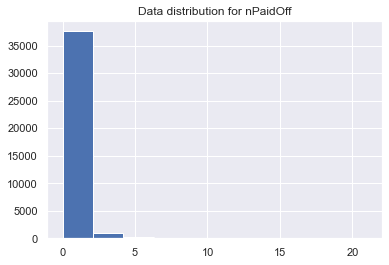

In [8]:
#plotting a histogram for 'nPaidOff' to observe the data distribution 
hist = df['nPaidOff'].hist(bins=10)
plt.title("Data distribution for nPaidOff")

The data distribution is more concentrated towards 0 however we will also check for whether the values are discrete or continuous in nature before deciding on a imputation type

In [9]:
#checking for value counts 
df['nPaidOff'].value_counts()

0.0     30813
1.0      4992
2.0      1795
3.0       673
4.0       317
5.0       147
6.0        89
7.0        46
8.0        24
9.0        13
11.0       10
13.0        9
12.0        6
14.0        5
10.0        5
19.0        5
18.0        5
20.0        3
15.0        1
21.0        1
17.0        1
16.0        1
Name: nPaidOff, dtype: int64

Given the fact that the data distribution is concentrated towards 0 and the data is discrete numeric values ranging from 0.0 to 21.0, we can impute the data on the mode value 

In [10]:
#imputing the data. Since clearly the most repeated value is 0 ,we fill the missing values with 0 
df['nPaidOff'] = df['nPaidOff'].fillna(0)

In [11]:
#checking for NaN values
print("Percentage missing values by column")
((df.isnull().sum()/len(df))*100).sort_values(ascending=False)

Percentage missing values by column


clarityFraudId                      16.987327
fpStatus                             0.023088
loanId                               0.000000
loanStatus                           0.000000
leadCost                             0.000000
leadType                             0.000000
state                                0.000000
originallyScheduledPaymentAmount     0.000000
loanAmount                           0.000000
isFunded                             0.000000
anon_ssn                             0.000000
approved                             0.000000
nPaidOff                             0.000000
originatedDate                       0.000000
originated                           0.000000
applicationDate                      0.000000
apr                                  0.000000
payFrequency                         0.000000
hasCF                                0.000000
dtype: float64

### Data Transformation

Here we will be identifying categorical data and converting it into numerical data which helps in improving accuracy as well as establish relationship with other variables during the construction of the LightGBM model

In [12]:
#getting all the columns which contain categorical variables 
list(df.select_dtypes(include=['object']))

['loanId',
 'anon_ssn',
 'payFrequency',
 'loanStatus',
 'state',
 'leadType',
 'fpStatus',
 'clarityFraudId']

Since we have already seen that 'loanId' and 'anon_ssn' are unique identifiers, we skip over those columns and check to see if we can perform encoding on the other columns listed

In [13]:
#get data distribution of 'payFrequency'
df['payFrequency'].value_counts()

B    22797
W    10248
M     2880
S     2628
I      429
Name: payFrequency, dtype: int64

In [14]:
#encode the categorical data for 'payFrequency'
newVals = {
    'payFrequency': {
        'B': 0,
        'W': 1,
        'M': 2,
        'S': 3,
        'I': 4
    }
}

df = df.replace(newVals)

In [15]:
#check for loanStatus
df['loanStatus'].value_counts()

Paid Off Loan                  11427
External Collection            11334
New Loan                        8112
Internal Collection             5564
Returned Item                   1182
Settlement Paid Off              708
Settled Bankruptcy               325
Pending Paid Off                 169
Charged Off Paid Off             159
Charged Off                        1
Settlement Pending Paid Off        1
Name: loanStatus, dtype: int64

As mentioned in the question document earlier, the 'loanStatus' column will be the target variable. The aim of the model is to assess whether for a given loan application, the risk will be good or bad. Since the output will be 2 discrete values we need to group together labels which are considered to be 'good' risk and those which are considered 'bad' risk

According to the definitions of the labels:
- 'Paid Off Loan' and 'Settlement Paid Off' would directly indicate that the applicant in question has fully paid the loan. This can be considered in group 1 (value of 1)
- 'Settled Bankruptcy' would mean the applicant is unable to pay their debts/loans and 'Charged Off' means a debt is unlikely to be collected so both can be considered to be in group 2 (value of 0)
- The third group would be all the remaining ones such as 'External Collection' and 'Pending Paid Off' which do not belong in either category as the collection of funds would be through third party or is still pending and hence would not be needed during model training  

In [16]:
#drop all rows which have a pending status aka third group 
valid_group = ['Paid Off Loan', 'Settlement Paid Off', 'Settled Bankruptcy', 'Charged Off']
df = df[df.loanStatus.isin(valid_group) != False]
#encode the values in 0 or 1 
new_loanstatus = {
    'loanStatus': {
        'Paid Off Loan': 1,
        'Settlement Paid Off': 1,
        'Settled Bankruptcy': 0,
        'Charged Off': 0
    }
}

df = df.replace(new_loanstatus)

In [17]:
df["loanStatus"].value_counts()

1    12135
0      326
Name: loanStatus, dtype: int64

In [18]:
df["leadType"].value_counts()

bvMandatory      4864
organic          3610
lead             2772
rc_returning      635
prescreen         528
california         26
lionpay            10
express             9
repeat              6
instant-offer       1
Name: leadType, dtype: int64

In [19]:
#perform one hot encoding 
df = pd.get_dummies(df, columns=['leadType'])

The data transformation has been done here.  
1. We did not perform any encoding on state as it was not needed (and will be removed later on)
2. No data transformation was performed on fpStatus and clarityFraudId as both columns will be removed in the later sections (clarityFraudId is just a unique identifier so encoding was not needed on it)

### Feature Engineering

In this section we will be generating new features from the existing ones which will help in establishing more interactions and potentially have a stronger correlation to the target variable as compared to the existing features.

First off, we will be creating a feature called 'processTime' which will give us the time taken to process an application. This is calculated using the difference between time provided for the originated date and application date. It may help us in establishing a feature that strongly correlates to loan application risk

In [20]:
df['processTime'] = (df['originatedDate'] - df['applicationDate']).dt.total_seconds() / 3600

### Data Visualization 

In this section we will visualize the data in order to check for correlations between the target and all the variables. This will help us in deciding on which features to keep and which features to drop

<AxesSubplot:>

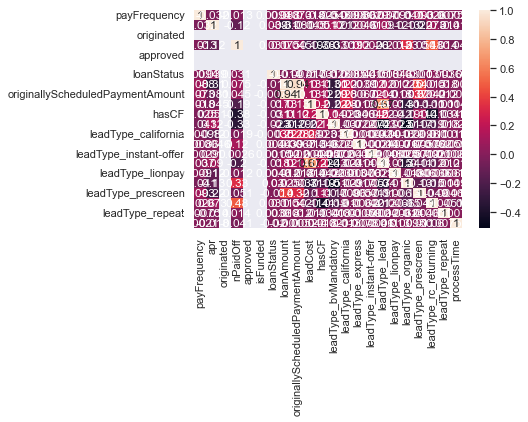

In [21]:
#making a correlation matrix 
df.corr()

#making a heatmap 
sn.heatmap(df.corr(), annot=True)

In [22]:
df["originated"].value_counts()

True    12461
Name: originated, dtype: int64

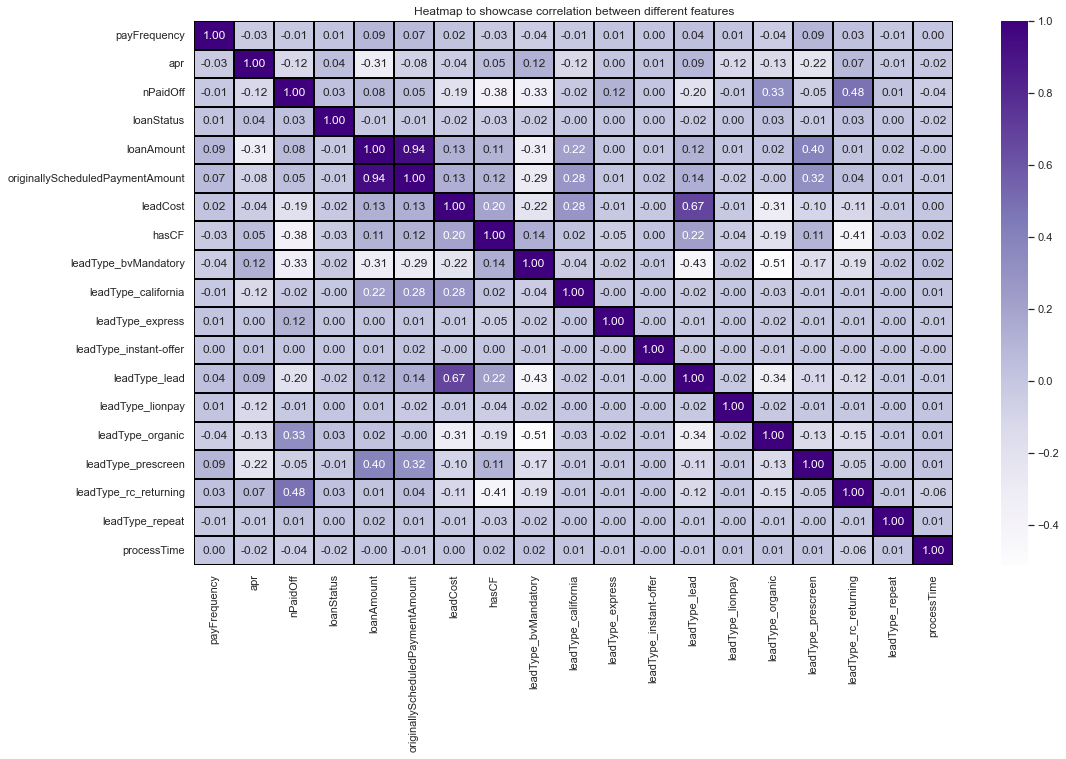

In [23]:
#we drop originated, approved and isFunded 
df_copy = df.copy()
df_copy.drop(['originated', 'isFunded', 'approved'], axis="columns", inplace=True)
plt.figure(figsize=(17, 10))
sn.heatmap(df_copy.corr(), cmap="Purples", linewidths=2, linecolor='black', annot=True, fmt=".2f")
plt.title("Heatmap to showcase correlation between different features")
plt.savefig("ppt_images/corr_graph.jpg")
plt.show()

As you can see from the heatmap above, 'loanStatus' does not seem to be strongly correlated with any feature. The only strongly coorelated features observed are: 
1. 'originallyScheduledPaymentAmount' and 'loanAmount' with a correlation coefficient value of 0.94
2. 'leadType (lead) and 'leadCost' with a correlation coefficient value of 0.67

### Feature Selection

In this section we will be removing irrelevant features in order to reduce dimensionality and improve our final model's performance

#### Rationale for removing the features

We are removing the following features with rationale provided for each:  
- 'fpStatus': This variable is not needed as the description given for the feature, as observed, is very similar to 'loanStatus'. In addition to that including 'fpStatus' may cause a data leakage as this data will not be available when the model is carrying out predictions. 
- 'originatedDate' and 'applicationDate': There is no need to include these two as none of them on their own will have an effect on the outcome of the loan application. A feature has alrady been engineered from these two features which is going to be a much better indicator. 
- 'originated', 'approved' and 'isFunded': All three are being removed for a similar reason and that is , the model here is predicting an outcome of whether the loan is repaid or not. As such the values for the three features here will be same for every entry. 

In [24]:
df['processTime'] = (df['originatedDate'] - df['applicationDate']).dt.seconds / 3600

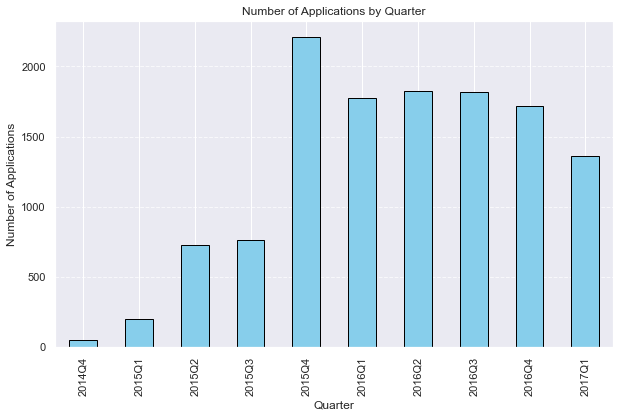

In [25]:
# Extract the quarter from the 'applicationDate' and create a new column 'Quarter'
df['Quarter'] = df['applicationDate'].dt.to_period('Q')

# Count the number of applications for each quarter
quarterly_counts = df['Quarter'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
quarterly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Applications by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Number of Applications')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("ppt_images/applications_by_quarter.jpg")

plt.show()

In [26]:
df.drop(['originated', 'isFunded', 'approved', 'originatedDate', 'applicationDate', 'fpStatus', 'state'], axis="columns", inplace=True)

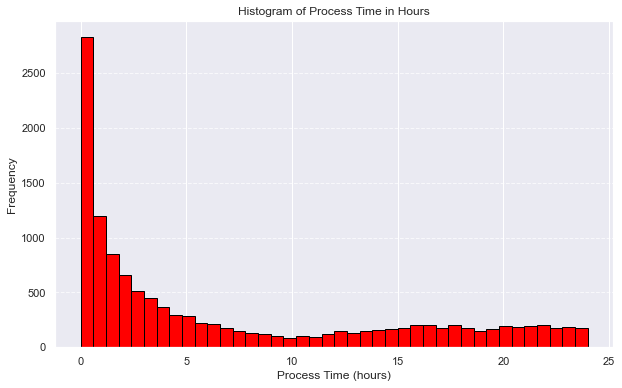

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(df['processTime'], bins=40, color='red', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Process Time in Hours')
plt.xlabel('Process Time (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("ppt_images/process_time_hist.jpg")

plt.show()

### Scaling/Normalization

In [28]:
df.describe()

,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF,leadType_bvMandatory,leadType_california,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat,processTime
count,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000
mean,0.677153,508.946662,0.590081,0.973838,629.297007,1661.688210,12.109863,0.795923,0.390338,0.002087,0.000722,0.000080,0.222454,0.000803,0.289704,0.042372,0.050959,0.000482,7.040876
std,1.006886,117.319897,1.389716,0.159622,451.761168,1202.830803,24.749500,0.403041,0.487846,0.045632,0.026866,0.008958,0.415911,0.028318,0.453643,0.201445,0.219923,0.021939,7.638825
min,0.000000,0.000000,0.000000,0.000000,100.000000,188.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,390.000000,0.000000,1.000000,350.000000,950.230000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.715000
50%,0.000000,565.000000,0.000000,1.000000,500.000000,1303.620000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.221111
75%,1.000000,590.000000,1.000000,1.000000,700.000000,1943.700000,10.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,13.698611
max,4.000000,705.590000,21.000000,1.000000,4687.000000,12550.080000,200.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.998333


In [29]:
#applying min-max scaling to loanAmount and originallyScheduledPaymentAmount
scaler = MinMaxScaler()
df[['loanAmount', 'originallyScheduledPaymentAmount']] = scaler.fit_transform(df[['loanAmount', 'originallyScheduledPaymentAmount']])

#applying box-cox to leadCost and nPaidOff as both of their data distribution is heavily concentrated 
#near 0 and is positively skewed
df['nPaidOff'], _ = boxcox(df['nPaidOff'] + 1)
df['leadCost'], _ = boxcox(df['leadCost'] + 1)

### Sampling 

Here we carry out sampling in order to ensure that we have equal number of both classes in training

In [30]:
#we will be using oversampling

#split data into x and y.
#drop the unique identifiers
X , y = df.drop(['loanId', 'anon_ssn', 'loanStatus', 'clarityFraudId', 'Quarter'], axis=1), df["loanStatus"]
print(f"Class distribution before sampling \n{(y.value_counts(normalize=True)*100).round(2).astype(str) + '%'}")
ros = RandomOverSampler(random_state=8)
X_new, y_new = ros.fit_resample(X, y)
print(f"\nClass distribution after oversampling \n{(y_new.value_counts(normalize=True)*100).round(2).astype(str) + '%'}")

Class distribution before sampling 
1    97.38%
0     2.62%
Name: loanStatus, dtype: object

Class distribution after oversampling 
1    50.0%
0    50.0%
Name: loanStatus, dtype: object


As it can be observed here, oversampling has added new samples for the minority class (which in this case is class '0'). We may decide to try undersampling as well depnding on the performance of the model which would reduce the number of samples from the majority class (class '1').

## Step 3: Model Building

In this section we are going to be building the LightGBM model. We may also carry out fine tuning but that will depend on the performance of the intial model. The performance metric used here will be AUC and not accuracy because accuracy as a performance indicator may be misleading due to the fact that majority of the class distribution is towards class '1'. ROC-AUC is a much better indicator in this case as it determines how well the model can discriminate between 'positive' and 'negative' classes

### Training

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=8)

In [32]:
#building the model 
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='auc')

[20]	training's auc: 0.888409	training's binary_logloss: 0.527503	valid_0's auc: 0.874206	valid_0's binary_logloss: 0.533317
[40]	training's auc: 0.948001	training's binary_logloss: 0.442826	valid_0's auc: 0.938591	valid_0's binary_logloss: 0.450115
[60]	training's auc: 0.972365	training's binary_logloss: 0.381915	valid_0's auc: 0.967767	valid_0's binary_logloss: 0.3903
[80]	training's auc: 0.985906	training's binary_logloss: 0.329828	valid_0's auc: 0.981853	valid_0's binary_logloss: 0.339463
[100]	training's auc: 0.990646	training's binary_logloss: 0.295255	valid_0's auc: 0.98692	valid_0's binary_logloss: 0.306568


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

Initial Model AUC:  93.05%


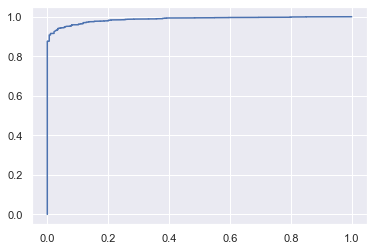

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:, 1])
# Plot the resulting ROC graph & calculate AUC    
plt.plot(fpr, tpr, label=f'(AUC = {metrics.roc_auc_score(y_test, model.predict(X_test)) * 100:.2f}%)')
AUC = metrics.roc_auc_score(y_test, model.predict(X_test))
print(f"Initial Model AUC: {AUC*100: .2f}%")

### Fine-Tuning

In this section we are going to try to fine-tune the model in order to increate the AUC score. The current model's AUC score is around 92% which is a good score but we will use grid search to check for optimal parameter values for the LightGBM model in order to further improve the model's performance

In [34]:
#initializing a LightGBM model and calling GridSearch on it 
new_model = lgb.LGBMClassifier(random_state=40)
param_grid = {
    'learning_rate': [0.1, 0.09, 0.05, 0.01],
    'max_depth': [-1, 3, 5, 7, 10],
    'num_leaves': [20, 30, 40, 50, 75, 100]
}

grid_search = GridSearchCV(new_model, param_grid, cv=5, scoring="roc_auc")
grid_result = grid_search.fit(X_train, y_train)

best_params = grid_result.best_params_
best_score = grid_result.best_score_

In [35]:
print(f"Model AUC after grid search : {best_score*100: .2f}%")

Model AUC after grid search :  99.98%


In [36]:
print(f"Optimal Model Parameters : \n{best_params}")

Optimal Model Parameters : 
{'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 100}


The performance of the model has improved significantly from 92.76% to 99.97% which means that the GridSearch worked better than expected.  
Here I will be talking about the paramters that have been experimented with which has resulted in the increase of ROC score for the model:  
1. Learning rate: The learning rate was increased from the initial model. A increased learning rate means faster convergence however this does come at a cost of overfitting.
2. Max depth: Setting a max_depth of -1 allows the trees to grow without any restrictions. This means that overall it allows for better generalization and in larger datasets, not having restrictions on depth can allow trees to capture a lot more information 
3. num_leaves: This indicates how many leaves can each tree have and in this case we have set it to 100 leaves as this is the optimal number. 

In [37]:
#creating the new improved model and fitting it on the training data
improved_model = lgb.LGBMClassifier(**best_params)
improved_model.fit(X_train, y_train)

LGBMClassifier(num_leaves=100)

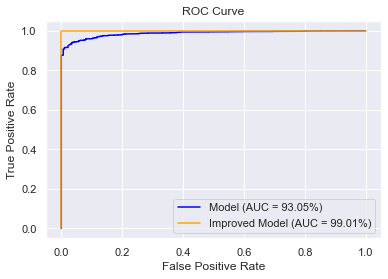

In [38]:
# Plot ROC curve for 'model'
fpr_model, tpr_model, thresholds_model = metrics.roc_curve(y_test, 
                                                           model.predict_proba(X_test)[:, 1])
plt.plot(fpr_model, tpr_model, label=f'Model (AUC = {metrics.roc_auc_score(y_test, model.predict(X_test)) * 100:.2f}%)',
         color='blue')

# Plot ROC curve for 'improved_model'
fpr_improved, tpr_improved, thresholds_improved = metrics.roc_curve(y_test, 
                                                                    improved_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_improved, tpr_improved, label=f'Improved Model (AUC = {metrics.roc_auc_score(y_test, improved_model.predict(X_test)) * 100:.2f}%)',
         color='orange')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.savefig("ppt_images/auc_comp.jpg")
# Show the plot
plt.show()


In [39]:
#save model in a folder 
model_folder = "../models/"

with open(model_folder + "inital_model.pkl", 'wb') as file:
    pickle.dump(improved_model, file)

### Model Evaluation and Summary

In [40]:
print('Training accuracy {:.4f}'.format(improved_model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(improved_model.score(X_test,y_test)))

Training accuracy 0.9971
Testing accuracy 0.9903


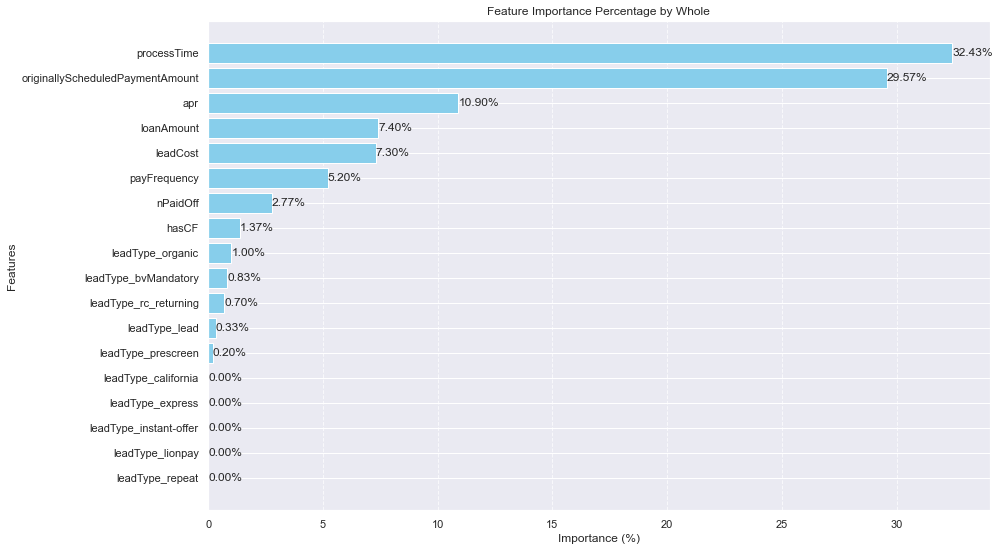

In [41]:
# Get feature names
feature_names = model.booster_.feature_name()

# Obtain feature importance as percentage by the whole
feature_impscore = model.feature_importances_
total_impscore = np.sum(feature_impscore)
feature_impscore_per = (feature_impscore / total_impscore) * 100

# Dictionary created and we have mapped the feature_name to its value (key:pair)
feature_imp_dict = dict(zip(feature_names, feature_impscore_per))
sorted_imp = dict(sorted(feature_imp_dict.items(), key=lambda x: x[1], reverse=True))
# 
plt.figure(figsize=(14, 9))
bars = plt.barh(list(sorted_imp.keys()), list(sorted_imp.values()), color='skyblue')
plt.xlabel('Importance (%)')
plt.ylabel('Features')
plt.title('Feature Importance Percentage by Whole')
plt.gca().invert_yaxis()
# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add label to each bar to represent the percentage 
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', ha='left', va='center')


plt.savefig("ppt_images/imp_chart.jpg")

plt.show()

From the plot above, we can see that the most important feature has been 'processTime' followed by 'orignallyScheduledPaymentAmount'.  
We can also see that the lead types have no real importance to the model as the highest importance percentage by a lead type is 0.70% only.  
Next, 'leadAmount', 'apr' and 'leadCost' play significant parts in the model and this makes sense as all three are related to the loan application and the quality of the loan application so they are expected to influence the final outcome of the loan application

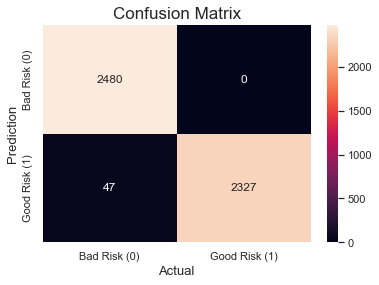

In [42]:
#making a confusion matrix
y_pred = improved_model.predict(X_test)
cm = metrics.confusion_matrix(y_test,y_pred)
class_labels = ["Bad Risk (0)", "Good Risk (1)"]
sn.heatmap(cm, annot=True, fmt="g", xticklabels=class_labels,
            yticklabels=class_labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.savefig("ppt_images/conf_matrix.jpg")
plt.show()

From the confusion matrix it can be observed that there are no false positves (i.e, no 'good' risk has been classified incorrectly) and a very small number of risks (50) have been misclassified as 'bad' risks

In [43]:
# make the html file 
from nbconvert import HTMLExporter
import nbformat

notebook_file = 'lightgbm_build.ipynb'

# Read the notebook
with open(notebook_file, 'r', encoding='utf-8') as notebook_file_content:
    notebook_content = nbformat.read(notebook_file_content, as_version=4)

# Create an HTMLExporter instance
html_exporter = HTMLExporter()

# Converting notebook to HTML file
(html_output, resources) = html_exporter.from_notebook_node(notebook_content)

html_output_file = 'lightgbm_build.html'

with open(html_output_file, 'w', encoding='utf-8') as html_file:
    html_file.write(html_output)

#confirmation message
print(f'The notebook has been successfully converted to HTML. Output saved to {html_output_file}.')

The notebook has been successfully converted to HTML. Output saved to lightgbm_build.html.
